In [1]:
# %load ./init.ipy
%reload_ext autoreload
%autoreload 2
from importlib import reload

import os
import sys
import logging
import warnings
import numpy as np
import astropy as ap
import scipy as sp
import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as plt

import h5py
import tqdm.notebook as tqdm

import kalepy as kale
import kalepy.utils
import kalepy.plot
print(kale.__version__)

import holodeck as holo
import holodeck.sam
from holodeck import cosmo, utils, plot
from holodeck.constants import MSOL, PC, YR, MPC, GYR

# Silence annoying numpy errors
np.seterr(divide='ignore', invalid='ignore', over='ignore')
warnings.filterwarnings("ignore", category=UserWarning)

# Plotting settings
mpl.rc('font', **{'family': 'serif', 'sans-serif': ['Times'], 'size': 15})
mpl.rc('lines', solid_capstyle='round')
mpl.rc('mathtext', fontset='cm')
plt.rcParams.update({'grid.alpha': 0.5})

log = holo.log
log.setLevel(logging.INFO)

# ---- Create initial population

pop = holo.population.Pop_Illustris()

# ---- Apply population modifiers
redz = cosmo.a_to_z(pop.scafa)

# resample to increase the number of binaries
#mod_resamp = holo.PM_Resample(resample=5.0)
# modify population (in-place)
#pop.modify(mod_resamp)
# get eccentricity
#mod_eccen = holo.PM_Eccentricity()
# modify population with eccentricity
#pop.modify(mod_eccen)

redz = cosmo.a_to_z(pop.scafa)

#print(pop.mass)

## SET attenuate=False in Dynamical_Friction_NFW() due to a still unsolved 
## bug which occurs in _radius_influence_dehnen(mbh, mstar, gamma=1.0), 
## line 1371 in evolution.py!
hards = [
    holo.evolution.Hard_GW,
    holo.evolution.Sesana_Scattering(),
    holo.evolution.Dynamical_Friction_NFW(attenuate=True),
]

acc_instance = holo.accretion.Accretion(accmod=None)
evo = holo.evolution.Evolution(pop, hards, debug=True, acc=acc_instance)
evo.evolve()

1.2.1
attenuating
(2*mbh/mstar)[inds] [1.18331652 1.25959825 3.23418287 1.10856007 1.00085214 2.25933523
 2.57924782]
line 1380, rinfl[inds] =  [-1.02497244e+21 -1.32369787e+22 -1.25701478e+21 -7.22386246e+21
 -7.01871487e+23 -3.02161352e+20 -4.00280246e+20]
rchar[inds] =  [8.27320330e+19 1.44266035e+21 5.58045488e+20 3.62824010e+20
 2.98854587e+20 1.01137043e+20 1.51040315e+20]
(2*mbh/mstar)[inds] [1.18331652 1.25959825 3.23418287 1.10856007 1.00085214 2.25933523
 2.57924782]
line 1380, rinfl[inds] =  [-1.02497244e+21 -1.32369787e+22 -1.25701478e+21 -7.22386246e+21
 -7.01871487e+23 -3.02161352e+20 -4.00280246e+20]
rchar[inds] =  [8.27320330e+19 1.44266035e+21 5.58045488e+20 3.62824010e+20
 2.98854587e+20 1.01137043e+20 1.51040315e+20]
rbnd[ind_nans] [-1.02497244e+21 -1.32369787e+22 -1.25701478e+21 -7.22386246e+21
 -7.01871487e+23 -3.02161352e+20 -4.00280246e+20]
rstar[ind_nans] [8.27320330e+19 1.44266035e+21 5.58045488e+20 3.62824010e+20
 2.98854587e+20 1.01137043e+20 1.51040315e+20]


NameError: name 'exit' is not defined

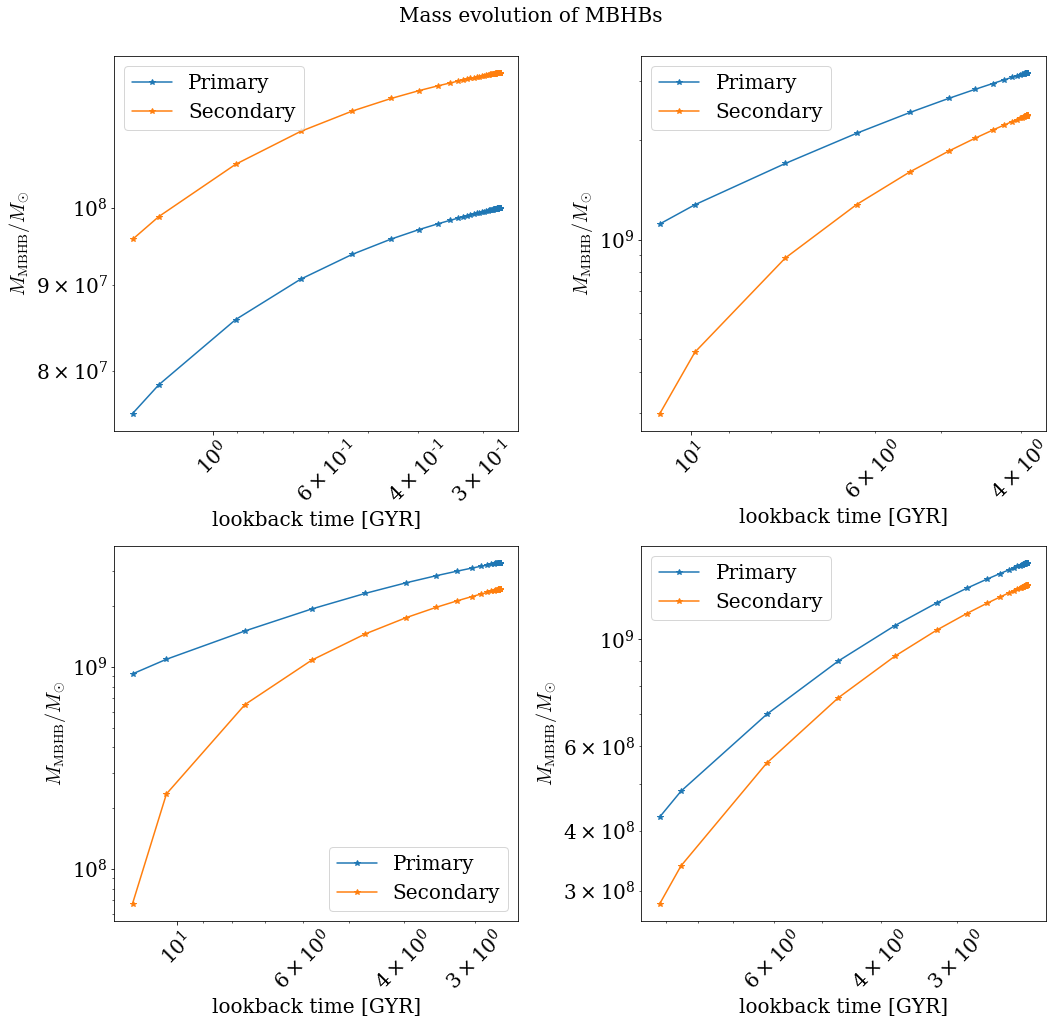

In [3]:
#Take a few random numbers and plot their mass evolutions as a function of time
import random
fs = 20

n_mbhb = evo.shape[0]

n_mbhb_to_plot = 4
inds_random_mbhb = []

p = 0
while p < n_mbhb_to_plot:
    x = random.randint(0,n_mbhb)
#     inds_random_mbhb.append(x)
#     p+=1
    inds_t_pos = evo.tlbk[x] > 0
    if len(evo.tlbk[x][inds_t_pos]) > 5:
        inds_random_mbhb.append(x)
        p += 1


fig, axs = plt.subplots(int(n_mbhb_to_plot/2),int(n_mbhb_to_plot/2),figsize=(15,15))
fig.suptitle('Mass evolution of MBHBs', fontsize=fs)
k = 0
for i in range(0,int(n_mbhb_to_plot/2)):
    for j in range(0,int(n_mbhb_to_plot/2)):
        inds_t_pos = evo.tlbk[inds_random_mbhb[k]] > 0
        time = (evo.tlbk[inds_random_mbhb[k]][inds_t_pos])
        masses = (evo.mass[inds_random_mbhb[k]][inds_t_pos])
        axs[i][j].loglog(time/GYR, masses.T[0]/MSOL, '*-', label = 'Primary')
        axs[i][j].loglog(time/GYR, masses.T[1]/MSOL, '*-', label = 'Secondary')
        axs[i][j].set_xlabel("lookback time [GYR]", fontsize=fs)
        axs[i][j].set_ylabel(r'$M_{\rm{MBHB}}/M_{\odot}$', fontsize=fs)
        k+=1
        axs[i][j].invert_xaxis()
        axs[i][j].legend(fontsize=fs)
        plt.setp(axs[i][j].get_xticklabels(which='both'), Fontsize=fs, rotation=45)
        plt.setp(axs[i][j].get_yticklabels(which='both'), Fontsize=fs)
        
plt.tight_layout()
fig.tight_layout(rect=[0, 0.03, 1, 0.95])


In [ ]:
fig, axs = plt.subplots(int(n_mbhb_to_plot/2),int(n_mbhb_to_plot/2),figsize=(15,15))
fontsize = 20
fig.suptitle('Accretion rates of MBHBs', fontsize=fontsize)

def mdot_eddington(mass):
    from holodeck.constants import SIGMA_T, MPRT, NWTG, MSOL, SPLC
    #choose radiative efficiency epsilon = 0.1
    eps = 0.1
    medd = (4.*np.pi*NWTG*MPRT)/(eps*SPLC*SIGMA_T) * mass
    return(medd)

k = 0
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i in range(0,int(n_mbhb_to_plot/2)):
    for j in range(0,int(n_mbhb_to_plot/2)):
        inds_t_pos = evo.tlbk[inds_random_mbhb[k]] > 0
        #print("evo.tlbk[inds_random_mbhb[k]][inds_t_pos] = ", evo.tlbk[inds_random_mbhb[k]][inds_t_pos])
        time = (evo.tlbk[inds_random_mbhb[k]][inds_t_pos])
        mdots = (evo.mdot[inds_random_mbhb[k]][inds_t_pos])
        masses = (evo.mass[inds_random_mbhb[k]][inds_t_pos])
        axs[i][j].loglog(time/GYR, mdots.T[0]/MSOL * GYR, '-', color = default_colors[0], label = r'$\dot{M}_1$')
        axs[i][j].loglog(time/GYR, mdots.T[1]/MSOL * GYR, '-', color = default_colors[1], label = r'$\dot{M}_2$')
        axs[i][j].loglog(time/GYR, mdot_eddington(masses.T[0])/MSOL * GYR, '--', color = default_colors[0], label = r'$\dot{M}_{1,\rm{Eddington}}$')
        axs[i][j].loglog(time/GYR, mdot_eddington(masses.T[1])/MSOL * GYR, '--', color = default_colors[1], label = r'$\dot{M}_{2,\rm{Eddington}}$')
        axs[i][j].set_xlabel("lookback time [GYR]", fontsize=fontsize)
        axs[i][j].set_ylabel(r'$ \dot{M} \, [M_{\odot}/\rm{GYR}]$', fontsize=fontsize)
        k+=1
        axs[i][j].invert_xaxis()
        axs[i][j].legend(fontsize=fontsize)
        plt.setp(axs[i][j].get_xticklabels(which='both'), Fontsize=fontsize, rotation=45)
        plt.setp(axs[i][j].get_yticklabels(which='both'), Fontsize=fontsize)
        
plt.tight_layout()
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
